Install HPI tool and get trainings-data

In [0]:
%tensorflow_version 2.x # Befehl für Google Colab für Tensorflow 2

# ohne Ausrufezeichen bei Ausführung im lokalen Notebook
!pip install --upgrade deeplearning2020
from deeplearning2020.datasets import ImageWoof

train_data, test_data, classes = ImageWoof.load_data()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # Befehl für Google Colab für Tensorflow 2`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
Requirement already up-to-date: deeplearning2020 in /usr/local/lib/python3.6/dist-packages (0.4.21)
/root/.keras/datasets/imagewoof2-320/train
Loaded 9025 images
/root/.keras/datasets/imagewoof2-320/val
Loaded 3929 images


Init *Tensorflow* and stuff

In [0]:
# TensorFlow ≥2.0 wird benötigt
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
else:
  print("GPU ok")

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, \
  Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
%matplotlib inline

GPU ok


Ok, take helpers, too

In [0]:
from deeplearning2020 import helpers

#helpers.plot_images(train_data_orig.take(9), classes)

Define the preprocessor

In [0]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [300, 300])
    return resized_image, label

Resize the pictures and prepare batch

In [0]:
# Festlegung der Batch Größe für die Datenvorbereitung
batch_size = 32 

# Durchmischen der Trainingsdaten, dass nicht mit sortierten Bildern trainiert wird 
train_data = train_data.shuffle(1000) 

print('shape des Trainigsdatensatzes vor dem preprocessing: ', train_data)

train_data = train_data.map(preprocess) \
  .batch(batch_size).prefetch(1)          
test_data = test_data.map(preprocess) \
  .batch(batch_size).prefetch(1)

print('shape des Traingingsdatensatzes nach dem preprocessing: ', train_data)

shape des Trainigsdatensatzes vor dem preprocessing:  <ShuffleDataset shapes: ((None, None, 3), ()), types: (tf.float32, tf.int64)>
shape des Traingingsdatensatzes nach dem preprocessing:  <PrefetchDataset shapes: ((None, 300, 300, 3), (None,)), types: (tf.float32, tf.int64)>


Show train data

In [0]:
#helpers.plot_images(train_data.unbatch().take(9), classes)

Dropout

In [0]:
from tensorflow.keras.layers import Dropout

Define the net

In [0]:
# model
learning_rate=0.01
momentum=0.9
decay=0.001
dense_neurons=800
n_filters=32
first_kernel_size=(7,7)

n_classes=len(classes)

activation='elu'

# Inputgröße muss 300x300 Pixel mit 3 RGB Farben betragen
input_layer = Input(shape=(300, 300, 3))
input = BatchNormalization(axis=[1,2])(input_layer)

# Convolutional Neural Network
# Entry Convolutional Layers (with pooling)
model = Conv2D(filters=n_filters, kernel_size=first_kernel_size, activation=activation )(input_layer)
model = BatchNormalization(axis=[1,2])(model)
model = MaxPooling2D((2,2))(model)

# 4 Conv layer (with pooling)
for i in range(2, 5):
  model = Conv2D(filters = i * n_filters, kernel_size=(3,3), activation=activation)(model)
  #model = Conv2D(filters = i * n_filters, kernel_size=(3,3), activation=activation, padding='same')(model)
  model = BatchNormalization(axis=[1,2])(model)
  model = MaxPooling2D((2,2))(model)

# final conv & pooling
model = Conv2D(filters = 5 * n_filters, kernel_size=(3,3), activation=activation, padding='same')(model)
model = BatchNormalization(axis=[1,2])(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# Fully connected layer
model = Dense(dense_neurons / 2, activation='tanh')(model)
model = BatchNormalization()(model)
model = Dropout(0.5)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

#Full model
CNN_model = Model(input_layer, output)

# Kompilieren des Modells
## Stochastic Gradient Descent -> langsamer aber genauer
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay)
## Adam -> schneller, für schnellere aber nicht 100% Ergebnisse
#optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
CNN_model.compile(loss="sparse_categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 294, 294, 256)     37888     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 256)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 145, 145, 256)     590080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 70, 32)        73760     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0     

Training

In [0]:
# Training des Modells
history = CNN_model.fit(
    train_data,
    epochs=10,
    validation_data=test_data
)

Epoch 1/10
283/283 [==============================] - 400s 1s/step - loss: 2.2321 - accuracy: 0.1556 - val_loss: 2.1205 - val_accuracy: 0.2171
Epoch 2/10
283/283 [==============================] - 398s 1s/step - loss: 2.0691 - accuracy: 0.2294 - val_loss: 1.9394 - val_accuracy: 0.3001
Epoch 3/10
283/283 [==============================] - 397s 1s/step - loss: 1.9745 - accuracy: 0.2748 - val_loss: 1.9159 - val_accuracy: 0.3209
Epoch 4/10
283/283 [==============================] - 398s 1s/step - loss: 1.9178 - accuracy: 0.3038 - val_loss: 1.9055 - val_accuracy: 0.3276
Epoch 5/10
283/283 [==============================] - 399s 1s/step - loss: 1.8808 - accuracy: 0.3231 - val_loss: 1.8190 - val_accuracy: 0.3632
Epoch 6/10
283/283 [==============================] - 398s 1s/step - loss: 1.8308 - accuracy: 0.3406 - val_loss: 1.8199 - val_accuracy: 0.3556
Epoch 7/10
283/283 [==============================] - 398s 1s/step - loss: 1.7987 - accuracy: 0.3512 - val_loss: 1.7857 - val_accuracy: 0.3749

Tranings-Ergebnis anzeigen

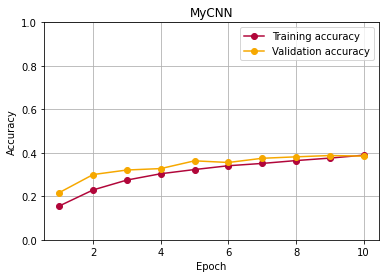

In [0]:
helpers.plot_history('MyCNN', history, 0)

Submission

In [0]:
#from deeplearning2020 import Submission
#Submission('4d712a6d0ae14f2a395c992ad3627476', '3', CNN_model).submit()

Using TensorFlow backend.


Model wird validiert...


100% (200 of 200) |######################| Elapsed Time: 0:09:15 Time:  0:09:15


Assignment 3 erfolgreich abgegeben!
Dein Model hat eine Accuracy von 39.0% auf unseren Validierungsdaten.
Du erhältst 41.0% der Punkte auf dieses Assignment.
Falls du bereits eine Abgabe mit höherer Bewertung abgegeben hast, wird automatisch das bessere Ergebnis gewählt.
